# Credit Card Fraud Detection

## Introduction

This notebook will be used to analyze the credit card fraud dataset and build a machine learning model to predict credit card fraud.

## Data

The dataset is available at: https://www.kaggle.com/datasets/ntnu-testimon/creditcardfraud

## Setup

Run to be sure all dependencies are installed

In [88]:
!pip install --upgrade scikit-learn imbalanced-learn pymongo python-dotenv mlxtend joblib seaborn

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\omarf\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import seaborn as sns
import numpy as np
import os
import joblib
from dotenv import load_dotenv

from collections import Counter
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from imblearn.over_sampling import SMOTE

# ML Models
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, classification_report,
                           silhouette_score, roc_auc_score)

# Load environment variables
load_dotenv()

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

In [90]:
# Load data from local CSV file
df = pd.read_csv("Dataset/credit_card_fraud_10k.csv")
df.head()

,transaction_id,amount,transaction_hour,merchant_category,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age,is_fraud
0,1,84.47,22,Electronics,0,0,66,3,40,0
1,2,541.82,3,Travel,1,0,87,1,64,0
2,3,237.01,17,Grocery,0,0,49,1,61,0
3,4,164.33,4,Grocery,0,1,72,3,34,0
4,5,30.53,15,Food,0,0,79,0,44,0


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   transaction_id       10000 non-null  int64  
 1   amount               10000 non-null  float64
 2   transaction_hour     10000 non-null  int64  
 3   merchant_category    10000 non-null  object 
 4   foreign_transaction  10000 non-null  int64  
 5   location_mismatch    10000 non-null  int64  
 6   device_trust_score   10000 non-null  int64  
 7   velocity_last_24h    10000 non-null  int64  
 8   cardholder_age       10000 non-null  int64  
 9   is_fraud             10000 non-null  int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 781.4+ KB


In [92]:
df.isnull().sum()

transaction_id         0
amount                 0
transaction_hour       0
merchant_category      0
foreign_transaction    0
location_mismatch      0
device_trust_score     0
velocity_last_24h      0
cardholder_age         0
is_fraud               0
dtype: int64

## Dataset Undertsanding (Exploration)
### We decided to do the following to check for imbalance and have better undertsanding of feature behavior:
1. View basic statistics (mean, min, max, std).
2. Count fraud vs non-fraud
3. Visualize imbalance using bar chart or pie chart.

In [93]:
summary = df.describe()
display(summary)

,transaction_id,amount,transaction_hour,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age,is_fraud
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,175.949849,11.593300,0.097800,0.085700,61.798900,2.008900,43.468700,0.015100
std,2886.89568,175.392827,6.922708,0.297059,0.279935,21.487053,1.432559,14.979147,0.121957
min,1.00000,0.000000,0.000000,0.000000,0.000000,25.000000,0.000000,18.000000,0.000000
25%,2500.75000,50.905000,6.000000,0.000000,0.000000,43.000000,1.000000,30.000000,0.000000
50%,5000.50000,122.095000,12.000000,0.000000,0.000000,62.000000,2.000000,44.000000,0.000000
75%,7500.25000,242.480000,18.000000,0.000000,0.000000,80.000000,3.000000,56.000000,0.000000
max,10000.00000,1471.040000,23.000000,1.000000,1.000000,99.000000,9.000000,69.000000,1.000000


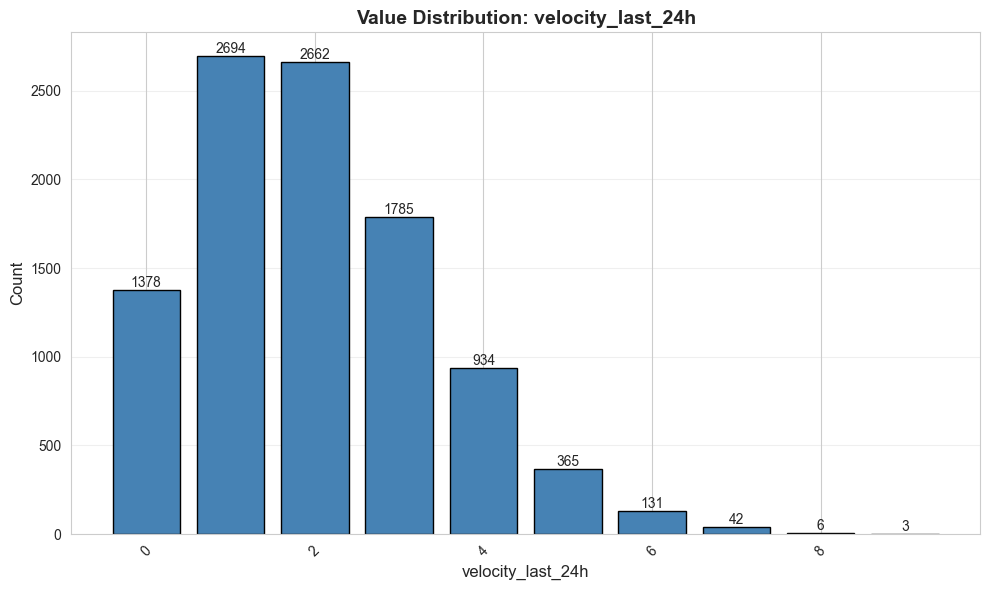

In [94]:
import matplotlib.pyplot as plt

feature = 'velocity_last_24h'

value_counts = df[feature].value_counts()

plt.figure(figsize=(10, 6))
bars = plt.bar(value_counts.index, value_counts.values, color='steelblue', edgecolor='black')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.xlabel(feature, fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title(f'Value Distribution: {feature}', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [95]:
print(df['is_fraud'].value_counts())

is_fraud
0    9849
1     151
Name: count, dtype: int64


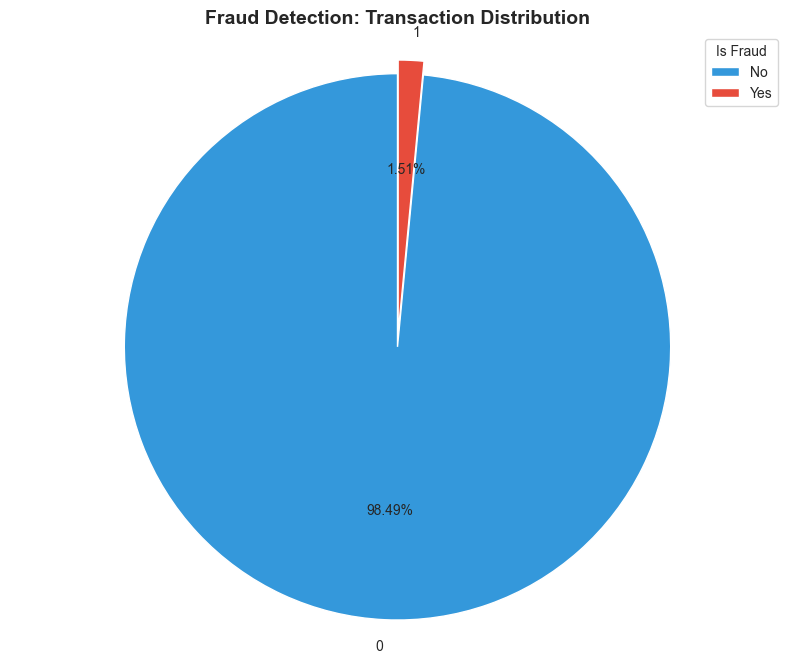

In [96]:
fraud_counts = df['is_fraud'].value_counts()

plt.figure(figsize=(10, 8))
explode = (0.05, 0)

plt.pie(fraud_counts.values, 
        labels=fraud_counts.index,
        autopct='%1.2f%%',
        startangle=90,
        explode=explode,
        shadow=False,
        colors=['#3498db', '#e74c3c'])

plt.title('Fraud Detection: Transaction Distribution', fontsize=14, fontweight='bold')
plt.legend(['No','Yes'], title="Is Fraud", loc="best")
plt.axis('equal')
plt.show()

## Data Preprocessing

### 3.1 Data Cleaning

Steps:

* Check for missing (null) values in every feature.
* Check for duplicate records and remove them.
* Validate data ranges (e.g. negative transaction amount).

In [97]:
df.isna().count()

transaction_id         10000
amount                 10000
transaction_hour       10000
merchant_category      10000
foreign_transaction    10000
location_mismatch      10000
device_trust_score     10000
velocity_last_24h      10000
cardholder_age         10000
is_fraud               10000
dtype: int64

In [98]:
duplicate = df[df.duplicated()]

display(duplicate)

,transaction_id,amount,transaction_hour,merchant_category,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age,is_fraud


In [99]:
df['merchant_category'].value_counts()

merchant_category
Food           2093
Clothing       2050
Travel         1990
Grocery        1944
Electronics    1923
Name: count, dtype: int64

In [100]:
df['velocity_last_24h'].value_counts()

velocity_last_24h
1    2694
2    2662
3    1785
0    1378
4     934
5     365
6     131
7      42
8       6
9       3
Name: count, dtype: int64

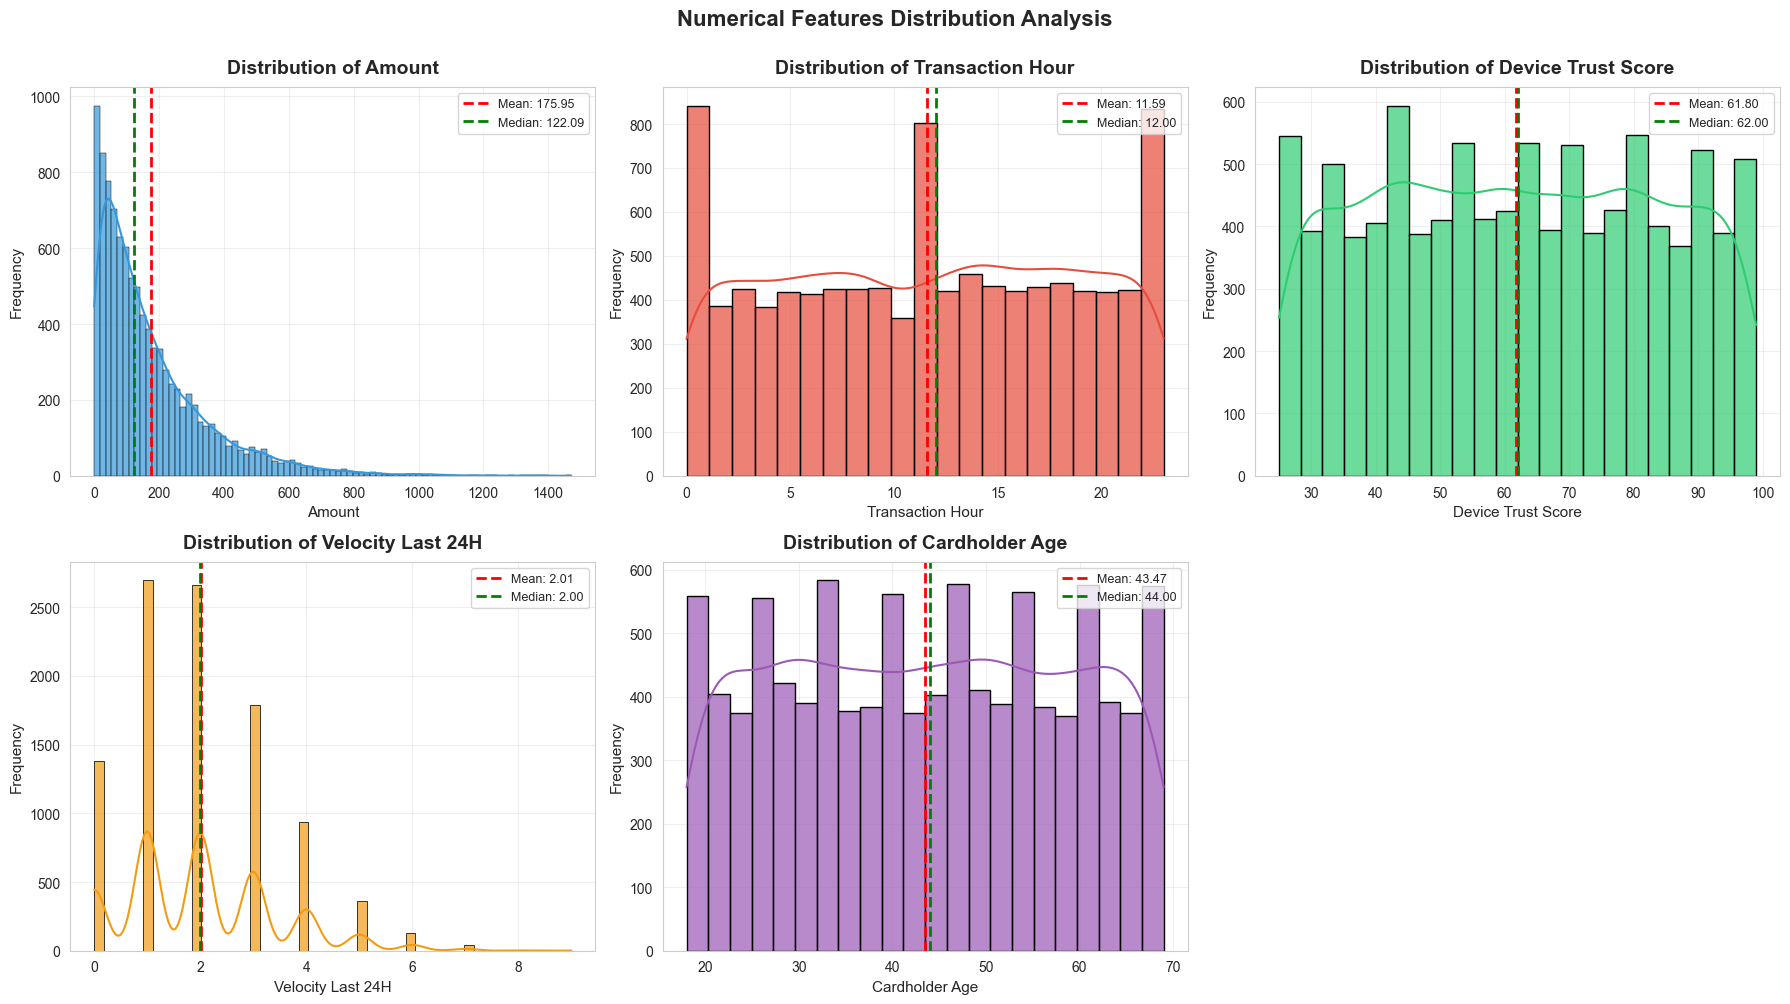

In [101]:
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'

num_cols = [
    "amount", "transaction_hour", "device_trust_score",
    "velocity_last_24h", "cardholder_age"
]

# Create subplots - all in one figure
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

# Define a nice color palette
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

for idx, col in enumerate(num_cols):
    # Create histogram with KDE
    sns.histplot(df[col], kde=True, ax=axes[idx], 
                 color=colors[idx], edgecolor='black', alpha=0.7)
    
    # Add mean and median lines
    mean_val = df[col].mean()
    median_val = df[col].median()
    
    axes[idx].axvline(mean_val, color='red', linestyle='--', 
                      linewidth=2, label=f'Mean: {mean_val:.2f}')
    axes[idx].axvline(median_val, color='green', linestyle='--', 
                      linewidth=2, label=f'Median: {median_val:.2f}')
    
    # Styling
    axes[idx].set_title(f'Distribution of {col.replace("_", " ").title()}', 
                        fontsize=14, fontweight='bold', pad=10)
    axes[idx].set_xlabel(col.replace("_", " ").title(), fontsize=11)
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].legend(loc='upper right', fontsize=9)
    axes[idx].grid(True, alpha=0.3)

# Remove the extra subplot
fig.delaxes(axes[5])

plt.suptitle('Numerical Features Distribution Analysis', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

### 3.2 Data Transformation

Steps:

* Normalize transaction amount.
* Encode Merchant Category.

In [102]:
le = LabelEncoder()
df['category_encoded'] = le.fit_transform(df['merchant_category'])

print("Original vs Encoded:")
print(df[['merchant_category', 'category_encoded']].head(10))
print("\nMapping:")
category_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(category_mapping)

joblib.dump(le, 'models/label_encoder.pkl')
joblib.dump(category_mapping, 'models/category_mapping.pkl')

Original vs Encoded:
  merchant_category  category_encoded
0       Electronics                 1
1            Travel                 4
2           Grocery                 3
3           Grocery                 3
4              Food                 2
5          Clothing                 0
6            Travel                 4
7       Electronics                 1
8           Grocery                 3
9           Grocery                 3

Mapping:
{'Clothing': np.int64(0), 'Electronics': np.int64(1), 'Food': np.int64(2), 'Grocery': np.int64(3), 'Travel': np.int64(4)}


['models/category_mapping.pkl']

In [103]:
df.head()

,transaction_id,amount,transaction_hour,merchant_category,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age,is_fraud,category_encoded
0,1,84.47,22,Electronics,0,0,66,3,40,0,1
1,2,541.82,3,Travel,1,0,87,1,64,0,4
2,3,237.01,17,Grocery,0,0,49,1,61,0,3
3,4,164.33,4,Grocery,0,1,72,3,34,0,3
4,5,30.53,15,Food,0,0,79,0,44,0,2


In [104]:
df['merchant_category'] = df['category_encoded']
df.drop(columns=['merchant_category','amount'])

,transaction_id,transaction_hour,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age,is_fraud,category_encoded
0,1,22,0,0,66,3,40,0,1
1,2,3,1,0,87,1,64,0,4
2,3,17,0,0,49,1,61,0,3
3,4,4,0,1,72,3,34,0,3
4,5,15,0,0,79,0,44,0,2
...,...,...,...,...,...,...,...,...,...
9995,9996,22,0,0,99,4,37,0,2
9996,9997,5,0,0,70,3,25,0,0
9997,9998,21,0,0,44,2,45,0,1
9998,9999,2,0,0,38,0,37,0,1


In [105]:
df.head()

,transaction_id,amount,transaction_hour,merchant_category,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age,is_fraud,category_encoded
0,1,84.47,22,1,0,0,66,3,40,0,1
1,2,541.82,3,4,1,0,87,1,64,0,4
2,3,237.01,17,3,0,0,49,1,61,0,3
3,4,164.33,4,3,0,1,72,3,34,0,3
4,5,30.53,15,2,0,0,79,0,44,0,2


## 3.3 Data Reduction

### Steps:

* Identify irrelevant or redundant features.
* Remove features with very low variance.
* Apply feature selection techniques: Correlation analysis

In [106]:
X = df.drop(columns=['is_fraud'])
y = df['is_fraud']

In [107]:
X.head()

,transaction_id,amount,transaction_hour,merchant_category,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age,category_encoded
0,1,84.47,22,1,0,0,66,3,40,1
1,2,541.82,3,4,1,0,87,1,64,4
2,3,237.01,17,3,0,0,49,1,61,3
3,4,164.33,4,3,0,1,72,3,34,3
4,5,30.53,15,2,0,0,79,0,44,2


We divide the dataset into:
- Training set -> 60%
- Validation set -> 20%
- Test set -> 20%

In [140]:
# divide into test and temp set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
# divide temp set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,   # 0.25 × 0.8 = 0.2
    stratify=y_temp,
    random_state=42
)


In [141]:
irrelevant_cols = [
    col for col in X_train.columns
    if 'id' in col.lower() or 'index' in col.lower()
]

display(irrelevant_cols)

X_train = X_train.drop(columns=irrelevant_cols)
X_test = X_test.drop(columns=irrelevant_cols)

['transaction_id']

In [142]:
X_train.head()

,amount,transaction_hour,merchant_category,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age,category_encoded
6981,138.45,19,4,1,0,87,0,42,4
6509,206.89,22,1,0,0,56,1,26,1
9110,516.59,10,3,0,0,32,3,37,3
5282,35.54,5,0,1,0,66,2,25,0
5777,28.43,13,1,0,0,33,1,52,1


In [143]:
# remove columns that are constant across the whole dataset if they exist

vt = VarianceThreshold(threshold=0)
X_vt = vt.fit_transform(X_train)

kept_features = X_train.columns[vt.get_support()] # found non constant features
X_train = pd.DataFrame(X_vt, columns=kept_features)

In [144]:
X_train.head()

,amount,transaction_hour,merchant_category,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age,category_encoded
0,138.45,19.0,4.0,1.0,0.0,87.0,0.0,42.0,4.0
1,206.89,22.0,1.0,0.0,0.0,56.0,1.0,26.0,1.0
2,516.59,10.0,3.0,0.0,0.0,32.0,3.0,37.0,3.0
3,35.54,5.0,0.0,1.0,0.0,66.0,2.0,25.0,0.0
4,28.43,13.0,1.0,0.0,0.0,33.0,1.0,52.0,1.0


In [145]:
corr_matrix = X_train.corr().abs()

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

to_drop = [
    column for column in upper.columns
    if any(upper[column] > 0.9)
]

for column in to_drop:
    correlated_with = upper.index[upper[column] > 0.9].tolist()
    for feature in correlated_with:
        print(f"- {column} is correlated with {feature} (score: {upper[column][feature]:.4f})")
        print(f"  -> Marking '{column}' for removal.") 
    X_train = X_train.drop(columns=column)
    X_test = X_test.drop(columns=column)
    X_val = X_val.drop(columns=column)


- category_encoded is correlated with merchant_category (score: 1.0000)
  -> Marking 'category_encoded' for removal.


In [146]:
X_train.head()

,amount,transaction_hour,merchant_category,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age
0,138.45,19.0,4.0,1.0,0.0,87.0,0.0,42.0
1,206.89,22.0,1.0,0.0,0.0,56.0,1.0,26.0
2,516.59,10.0,3.0,0.0,0.0,32.0,3.0,37.0
3,35.54,5.0,0.0,1.0,0.0,66.0,2.0,25.0
4,28.43,13.0,1.0,0.0,0.0,33.0,1.0,52.0


### Scaling the dataset now before handling imbalance

In [147]:
feature_cols = X_train.columns


# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_scaled, columns=feature_cols)


joblib.dump(scaler, 'models/scaler.pkl')

['models/scaler.pkl']

## Handling Class Imbalance

### Steps:

* Verify imbalance ratio again.
* Choose imbalance technique: Oversampling (e.g. SMOTE)

In [148]:
print(y_train.value_counts())

is_fraud
0    5909
1      91
Name: count, dtype: int64


In [149]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

y_train_balanced.value_counts()

is_fraud
0    5909
1    5909
Name: count, dtype: int64

# Big Data Component-MongoDB
## Why MongoDB?
* Handles large transaction volumes
* Schema-flexible (different transaction attributes)
* Fast filtering & querying (important for fraud analysis)

## Transaction Document Structure

Each transaction = one document

## Connect to MongoDB & Load dataset (CSV → MongoDB)

In [119]:
from pymongo import MongoClient
from pymongo.server_api import ServerApi

In [120]:
# Load MongoDB credentials from .env
MONGODB_USERNAME = os.getenv('MONGODB_USERNAME')
MONGODB_PASSWORD = os.getenv('MONGODB_PASSWORD')
MONGODB_CLUSTER = os.getenv('MONGODB_CLUSTER')
MONGODB_DATABASE = os.getenv('MONGODB_DATABASE')
MONGODB_APP_NAME = os.getenv('MONGODB_APP_NAME')

# Determine protocol (mongodb+srv:// for Atlas, mongodb:// for local/standard)
protocol = "mongodb+srv"
if ":" in MONGODB_CLUSTER or "localhost" in MONGODB_CLUSTER:
    protocol = "mongodb"

# Construct URI based on protocol and presence of credentials
if protocol == "mongodb+srv":
    uri = f"mongodb+srv://{MONGODB_USERNAME}:{MONGODB_PASSWORD}@{MONGODB_CLUSTER}/?appName={MONGODB_APP_NAME}"
else:
    if MONGODB_USERNAME and MONGODB_PASSWORD:
        # For local MongoDB, we usually need to specify authSource=admin
        uri = f"mongodb://{MONGODB_USERNAME}:{MONGODB_PASSWORD}@{MONGODB_CLUSTER}/?authSource=admin&appName={MONGODB_APP_NAME}"
    else:
        uri = f"mongodb://{MONGODB_CLUSTER}/?appName={MONGODB_APP_NAME}"

# Create a new client and connect to the server
try:
    if protocol == "mongodb+srv":
        client = MongoClient(uri, server_api=ServerApi('1'))
    else:
        client = MongoClient(uri)
    
    # Send a ping to confirm a successful connection
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(f"Connection failed: {e}")
    print("If using local MongoDB, ensure the service is running: brew services start mongodb-community@7.0")


Pinged your deployment. You successfully connected to MongoDB!


In [121]:
# Connect to database and collection using .env variables
protocol = "mongodb+srv"
if ":" in MONGODB_CLUSTER or "localhost" in MONGODB_CLUSTER:
    protocol = "mongodb"

if protocol == "mongodb+srv":
    uri_full = f"mongodb+srv://{MONGODB_USERNAME}:{MONGODB_PASSWORD}@{MONGODB_CLUSTER}/{MONGODB_DATABASE}?retryWrites=true&w=majority"
else:
    if MONGODB_USERNAME and MONGODB_PASSWORD:
        uri_full = f"mongodb://{MONGODB_USERNAME}:{MONGODB_PASSWORD}@{MONGODB_CLUSTER}/{MONGODB_DATABASE}?authSource=admin"
    else:
        uri_full = f"mongodb://{MONGODB_CLUSTER}/{MONGODB_DATABASE}"

client = MongoClient(uri_full)
db_big_data = client[MONGODB_DATABASE]
collection = db_big_data[os.getenv('MONGODB_COLLECTION', 'transactions')]

print(f"Connected to database: {MONGODB_DATABASE}")


Connected to database: cred_card_fraud


In [122]:
# Load data from MongoDB collection
df_from_mongo = pd.DataFrame(list(collection.find()))

# If _id column exists from MongoDB, drop it
if '_id' in df_from_mongo.columns:
    df_from_mongo = df_from_mongo.drop('_id', axis=1)

print(f"Loaded {len(df_from_mongo)} records from MongoDB")
df_from_mongo.head()

Loaded 11818 records from MongoDB


,amount,transaction_hour,merchant_category,foreign_transaction,location_mismatch,device_trust_score,velocity_last_24h,cardholder_age,is_fraud
0,138.45,19.0,4.0,1.0,0.0,87.0,0.0,42.0,0
1,206.89,22.0,1.0,0.0,0.0,56.0,1.0,26.0,0
2,516.59,10.0,3.0,0.0,0.0,32.0,3.0,37.0,0
3,35.54,5.0,0.0,1.0,0.0,66.0,2.0,25.0,0
4,28.43,13.0,1.0,0.0,0.0,33.0,1.0,52.0,0


In [123]:
# Prepare the CLEANED and BALANCED data for MongoDB insertion
# Combine X_train with y_train (these are already balanced from SMOTE)
df_balanced = X_train.copy()
df_balanced['is_fraud'] = y_train.values

# Add feature names back (these are scaled values)
# For MongoDB, let's store both the balanced training data AND original test data
print(f"Balanced training data shape: {df_balanced.shape}")
print(f"Class distribution: {df_balanced['is_fraud'].value_counts().to_dict()}")

# Convert to records for MongoDB
records_balanced = df_balanced.to_dict(orient="records")
print(f"Prepared {len(records_balanced)} balanced records for insertion.")


Balanced training data shape: (6000, 9)
Class distribution: {0: 5909, 1: 91}
Prepared 6000 balanced records for insertion.


## Inserting csv into collection called "Transaction" in fraud_detection_db database on mongoDB

In [124]:
# Clear existing data and insert the balanced dataset
collection.delete_many({})  # Clear old data
result = collection.insert_many(records_balanced)
print(f"Inserted {len(result.inserted_ids)} balanced records into MongoDB")
print(f"Collection now has {collection.count_documents({})} documents")


Inserted 6000 balanced records into MongoDB
Collection now has 6000 documents


## Writing some Queries

### 4.1 Retrieve ALL fraud cases

In [125]:
fraud_cases = collection.find({"is_fraud": 1}).limit(5)

for case in fraud_cases:
    display(case)


{'_id': ObjectId('695486045f38fcd6521fccef'),
 'amount': 84.19,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 21.0,
 'is_fraud': 1}

{'_id': ObjectId('695486045f38fcd6521fcd11'),
 'amount': 255.67,
 'transaction_hour': 19.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 25.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 44.0,
 'is_fraud': 1}

{'_id': ObjectId('695486045f38fcd6521fcd4b'),
 'amount': 416.2,
 'transaction_hour': 0.0,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 30.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 52.0,
 'is_fraud': 1}

{'_id': ObjectId('695486045f38fcd6521fcda7'),
 'amount': 47.58,
 'transaction_hour': 1.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 41.0,
 'is_fraud': 1}

{'_id': ObjectId('695486045f38fcd6521fce05'),
 'amount': 122.13,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 35.0,
 'is_fraud': 1}

### 4.2 Filter transactions by amount

In [126]:
high_amount = collection.find({"amount": {"$gt": 1000}}).limit(5)

for amount in high_amount:
    display(amount)

{'_id': ObjectId('695486045f38fcd6521fce2e'),
 'amount': 1001.1,
 'transaction_hour': 0.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 64.0,
 'velocity_last_24h': 4.0,
 'cardholder_age': 32.0,
 'is_fraud': 0}

{'_id': ObjectId('695486045f38fcd6521fd792'),
 'amount': 1004.26,
 'transaction_hour': 23.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 90.0,
 'velocity_last_24h': 3.0,
 'cardholder_age': 30.0,
 'is_fraud': 0}

{'_id': ObjectId('695486045f38fcd6521fdb4f'),
 'amount': 1009.55,
 'transaction_hour': 2.0,
 'merchant_category': 3.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 37.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 27.0,
 'is_fraud': 1}

{'_id': ObjectId('695486045f38fcd6521fe2cd'),
 'amount': 1009.57,
 'transaction_hour': 14.0,
 'merchant_category': 0.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 33.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 48.0,
 'is_fraud': 0}

{'_id': ObjectId('695486045f38fcd6521fd2fd'),
 'amount': 1025.08,
 'transaction_hour': 23.0,
 'merchant_category': 0.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 0.0,
 'device_trust_score': 42.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 64.0,
 'is_fraud': 0}

### 3.3 Fraud + high amount (combined query)

In [127]:
Big_thief = collection.find({
    "is_fraud": 1,
    "amount": {"$gt": 500}
}).limit(5)

for thieves in Big_thief:
    display(thieves)

{'_id': ObjectId('695486045f38fcd6521fcea6'),
 'amount': 1103.19,
 'transaction_hour': 1.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 36.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 29.0,
 'is_fraud': 1}

{'_id': ObjectId('695486045f38fcd6521fd080'),
 'amount': 737.06,
 'transaction_hour': 0.0,
 'merchant_category': 2.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 65.0,
 'velocity_last_24h': 5.0,
 'cardholder_age': 51.0,
 'is_fraud': 1}

{'_id': ObjectId('695486045f38fcd6521fd271'),
 'amount': 950.41,
 'transaction_hour': 1.0,
 'merchant_category': 4.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 1.0,
 'device_trust_score': 70.0,
 'velocity_last_24h': 2.0,
 'cardholder_age': 60.0,
 'is_fraud': 1}

{'_id': ObjectId('695486045f38fcd6521fd2d9'),
 'amount': 701.79,
 'transaction_hour': 2.0,
 'merchant_category': 4.0,
 'foreign_transaction': 1.0,
 'location_mismatch': 1.0,
 'device_trust_score': 94.0,
 'velocity_last_24h': 1.0,
 'cardholder_age': 20.0,
 'is_fraud': 1}

{'_id': ObjectId('695486045f38fcd6521fd4d7'),
 'amount': 1036.82,
 'transaction_hour': 0.0,
 'merchant_category': 1.0,
 'foreign_transaction': 0.0,
 'location_mismatch': 0.0,
 'device_trust_score': 28.0,
 'velocity_last_24h': 0.0,
 'cardholder_age': 20.0,
 'is_fraud': 1}

### 4.4 Fraud cases by merchant category

In [128]:
grocery_thief = collection.find({
    "is_fraud": 1,
    "merchant_category": "Grocery"
}).limit(10)

for thieves in grocery_thief:
    display(thieves)

## Indexing

### Create indexes

In [129]:
collection.create_index("is_fraud")
collection.create_index("amount")

'amount_1'

# Machine Learning Models for Credit Card Fraud Detection

We will train and fine-tune the following models:
1. **K-Means Clustering** - Unsupervised anomaly detection
2. **Naïve Bayes** - Probabilistic classification
3. **Decision Trees** - Rule-based classification
4. **Logistic Regression** - Binary classification (instead of Linear Regression for classification)

**Note:** Apriori is for association rule mining (market basket analysis), not directly for fraud classification. We'll include it for pattern discovery.
Linear Regression is for continuous target prediction, so we use Logistic Regression for binary fraud classification.

## 1. K-Means Clustering (Unsupervised Anomaly Detection)

K-Means can identify anomalous transactions by clustering normal transactions and flagging outliers.

K=2, Silhouette Score: 0.6812
K=3, Silhouette Score: 0.6263
K=4, Silhouette Score: 0.5320
K=5, Silhouette Score: 0.5405
K=6, Silhouette Score: 0.4779
K=7, Silhouette Score: 0.4694
K=8, Silhouette Score: 0.4491
K=9, Silhouette Score: 0.3900
K=10, Silhouette Score: 0.3717


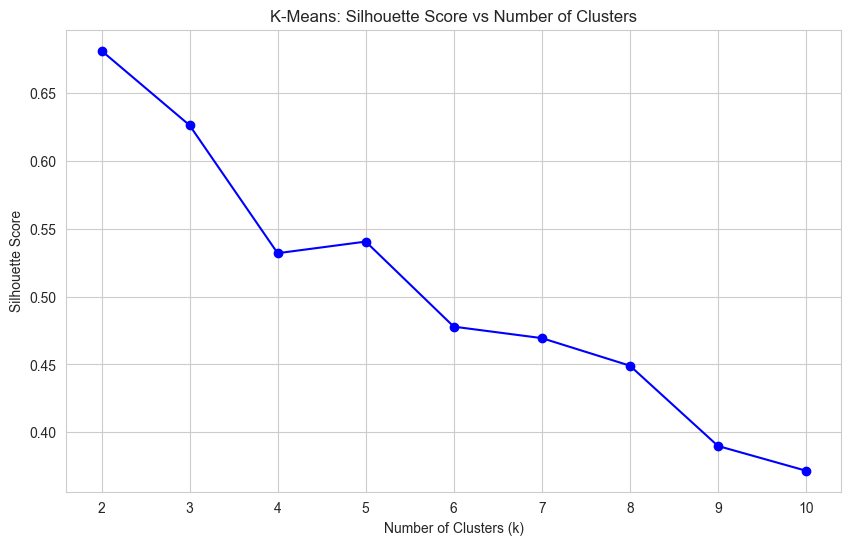


Optimal number of clusters: 2


In [130]:
# K-Means with hyperparameter tuning - finding optimal k
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train_balanced)
    score = silhouette_score(X_train_balanced, kmeans.labels_)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score: {score:.4f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('K-Means: Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.show()

# Find optimal k
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters: {optimal_k}")

Training K-Means on 5909 normal transactions
Percentile 85: Precision=0.006, Recall=0.067, F1=0.011
Percentile 90: Precision=0.004, Recall=0.033, F1=0.008
Percentile 95: Precision=0.008, Recall=0.033, F1=0.013

K-Means Anomaly Detection Results (90th percentile threshold):
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      1970
           1       0.00      0.03      0.01        30

    accuracy                           0.87      2000
   macro avg       0.49      0.46      0.47      2000
weighted avg       0.97      0.87      0.92      2000

Accuracy: 0.8715


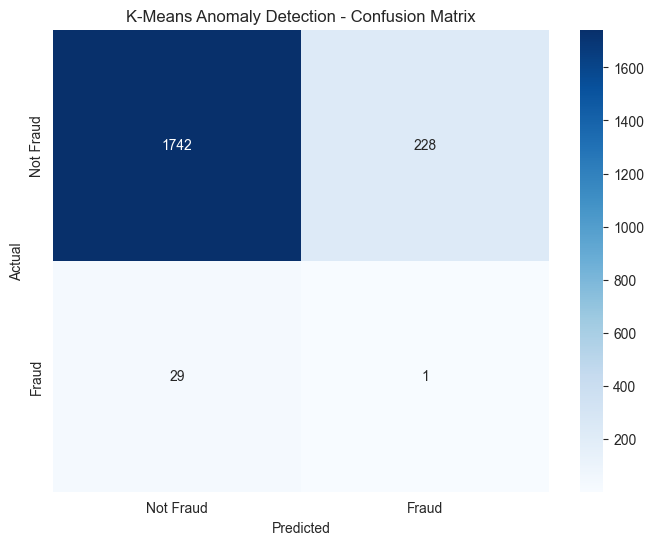

In [131]:
# K-Means for Anomaly Detection - IMPROVED APPROACH
# Train K-Means ONLY on non-fraud (normal) transactions to learn normal patterns
X_train_normal = X_train_balanced[y_train_balanced == 0]
print(f"Training K-Means on {len(X_train_normal)} normal transactions")

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_final.fit(X_train_normal)

# For fraud detection, we use distance from cluster centers as anomaly score
train_distances = kmeans_final.transform(X_train_normal).min(axis=1)
test_distances = kmeans_final.transform(X_test).min(axis=1)

# Use a more aggressive threshold to catch more fraud
# Try different percentiles to find a good balance
percentiles = [85, 90, 95]
for p in percentiles:
    thresh = np.percentile(train_distances, p)
    preds = (test_distances > thresh).astype(int)
    rec = recall_score(y_test, preds, zero_division=0)
    prec = precision_score(y_test, preds, zero_division=0)
    f1 = f1_score(y_test, preds, zero_division=0)
    print(f"Percentile {p}: Precision={prec:.3f}, Recall={rec:.3f}, F1={f1:.3f}")

# Use 90th percentile for better fraud detection
threshold = np.percentile(train_distances, 90)
kmeans_predictions = (test_distances > threshold).astype(int)

print("\nK-Means Anomaly Detection Results (90th percentile threshold):")
print(classification_report(y_test, kmeans_predictions))
print(f"Accuracy: {accuracy_score(y_test, kmeans_predictions):.4f}")

# Save K-Means model
joblib.dump(kmeans_final, 'models/kmeans_model.pkl')
joblib.dump(threshold, 'models/kmeans_threshold.pkl')

# Confusion Matrix
cm = confusion_matrix(y_test, kmeans_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Fraud', 'Fraud'], 
            yticklabels=['Not Fraud', 'Fraud'])
plt.title('K-Means Anomaly Detection - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


## 2. Apriori - Association Rule Mining

Apriori discovers frequent patterns in fraud transactions. We'll convert transactions to itemsets for analysis.

In [133]:
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Create categorical bins for Apriori analysis
# Recombine features and target for Apriori
# Use the cleaned BUT NOT SCALED version of the data
df_apriori = X_train.copy()
df_apriori['is_fraud'] = y_train

# Bin continuous variables
df_apriori['amount_bin'] = pd.cut(df_apriori['amount'], bins=[0, 100, 500, 1000, float('inf')], 
                                   labels=['low_amount', 'medium_amount', 'high_amount', 'very_high_amount'])
df_apriori['hour_bin'] = pd.cut(df_apriori['transaction_hour'], bins=[0, 6, 12, 18, 24], 
                                 labels=['night', 'morning', 'afternoon', 'evening'])
df_apriori['age_bin'] = pd.cut(df_apriori['cardholder_age'], bins=[0, 25, 40, 60, 100], 
                                labels=['young', 'adult', 'middle_age', 'senior'])
df_apriori['trust_bin'] = pd.cut(df_apriori['device_trust_score'], bins=[0, 33, 66, 100], 
                                  labels=['low_trust', 'medium_trust', 'high_trust'])

# Filter only fraud cases for pattern discovery
df_fraud = df_apriori[df_apriori['is_fraud'] == 1]

# Create transactions as list of items
transactions = []
for _, row in df_fraud.iterrows():
    transaction = [
        f"category_{row['merchant_category']}",
        str(row['amount_bin']),
        str(row['hour_bin']),
        f"foreign_{row['foreign_transaction']}",
        f"location_mismatch_{row['location_mismatch']}",
        str(row['trust_bin']),
        str(row['age_bin'])
    ]
    transactions.append(transaction)

print(f"Number of fraud transactions for Apriori: {len(transactions)}")
print(f"Sample transaction: {transactions[0] if transactions else 'No transactions'}")

Number of fraud transactions for Apriori: 58
Sample transaction: ['category_0.0', 'low_amount', 'evening', 'foreign_0.0', 'location_mismatch_0.0', 'low_trust', 'middle_age']


In [134]:
# Apply Transaction Encoder
te = TransactionEncoder()
te_array = te.fit_transform(transactions)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

# Apply Apriori with different min_support values for tuning
min_supports = [0.05, 0.1, 0.15, 0.2]

for min_sup in min_supports:
    frequent_itemsets = apriori(df_encoded, min_support=min_sup, use_colnames=True)
    print(f"Min Support: {min_sup} -> Found {len(frequent_itemsets)} frequent itemsets")

# Use optimal min_support
optimal_min_support = 0.1
frequent_itemsets = apriori(df_encoded, min_support=optimal_min_support, use_colnames=True)

if len(frequent_itemsets) > 0:
    # Generate association rules
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
    rules = rules.sort_values('lift', ascending=False)
    
    print(f"\nTop Association Rules in Fraud Transactions:")
    print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))
    
    # Save rules for Streamlit
    rules.to_pickle('models/apriori_rules.pkl')
    joblib.dump(te, 'models/transaction_encoder.pkl')
else:
    print("No frequent itemsets found. Try lowering min_support.")

Min Support: 0.05 -> Found 696 frequent itemsets
Min Support: 0.1 -> Found 225 frequent itemsets
Min Support: 0.15 -> Found 101 frequent itemsets
Min Support: 0.2 -> Found 59 frequent itemsets

Top Association Rules in Fraud Transactions:
                                 antecedents  \
633                   (evening, foreign_0.0)   
632               (category_0.0, middle_age)   
629       (evening, foreign_0.0, middle_age)   
636                           (category_0.0)   
201               (category_0.0, middle_age)   
627  (category_0.0, foreign_0.0, middle_age)   
204                                (evening)   
626     (category_0.0, foreign_0.0, evening)   
639                             (middle_age)   
630              (category_0.0, foreign_0.0)   

                              consequents   support  confidence      lift  
633            (category_0.0, middle_age)  0.103448    0.600000  4.350000  
632                (evening, foreign_0.0)  0.103448    0.750000  4.350000  
629 

## 3. Logistic Regression (Classification)

Using Logistic Regression instead of Linear Regression for binary classification (fraud/not fraud).

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Logistic Regression Parameters: {'C': 1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
Best CV F1 Score: 0.9786

⚠️ Overfitting Check:
   Train F1: 0.9791
   Test F1:  0.0577
   Gap:      0.9214 (OVERFITTING!)

Logistic Regression Test Results:
              precision    recall  f1-score   support

           0       0.99      0.76      0.86      1970
           1       0.03      0.50      0.06        30

    accuracy                           0.76      2000
   macro avg       0.51      0.63      0.46      2000
weighted avg       0.98      0.76      0.85      2000

Accuracy: 0.7550
ROC-AUC: 0.7134


C:\Users\omarf\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


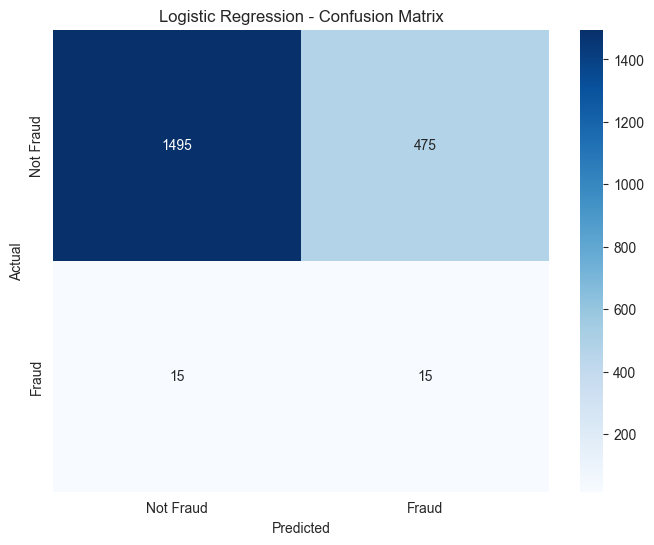

In [150]:
# Logistic Regression with GridSearch for hyperparameter tuning
lr_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000]
}

lr = LogisticRegression(random_state=42)
lr_grid = GridSearchCV(lr, lr_params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
lr_grid.fit(X_train_balanced, y_train_balanced)

print(f"Best Logistic Regression Parameters: {lr_grid.best_params_}")
print(f"Best CV F1 Score: {lr_grid.best_score_:.4f}")

# Evaluate on test set
lr_best = lr_grid.best_estimator_
lr_predictions = lr_best.predict(X_test)

# Check for overfitting
train_f1_lr = f1_score(y_train_balanced, lr_best.predict(X_train_balanced))
test_f1_lr = f1_score(y_test, lr_predictions)
print(f"\n⚠️ Overfitting Check:")
print(f"   Train F1: {train_f1_lr:.4f}")
print(f"   Test F1:  {test_f1_lr:.4f}")
print(f"   Gap:      {train_f1_lr - test_f1_lr:.4f} {'(OK)' if abs(train_f1_lr - test_f1_lr) < 0.1 else '(OVERFITTING!)'}")

print("\nLogistic Regression Test Results:")
print(classification_report(y_test, lr_predictions))
print(f"Accuracy: {accuracy_score(y_test, lr_predictions):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, lr_best.predict_proba(X_test)[:, 1]):.4f}")

# Save model
joblib.dump(lr_best, 'models/logistic_regression_model.pkl')

# Confusion Matrix
cm = confusion_matrix(y_test, lr_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Fraud', 'Fraud'], 
            yticklabels=['Not Fraud', 'Fraud'])
plt.title('Logistic Regression - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


## 4. Naïve Bayes Classifier

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best Naive Bayes Parameters: {'var_smoothing': 1e-12}
Best CV F1 Score: 0.9458

⚠️ Overfitting Check:
   Train F1: 0.9458
   Test F1:  0.2190
   Gap:      0.7269 (OVERFITTING!)

Naïve Bayes Test Results:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94      1970
           1       0.12      1.00      0.22        30

    accuracy                           0.89      2000
   macro avg       0.56      0.95      0.58      2000
weighted avg       0.99      0.89      0.93      2000

Accuracy: 0.8930
ROC-AUC: 0.9872


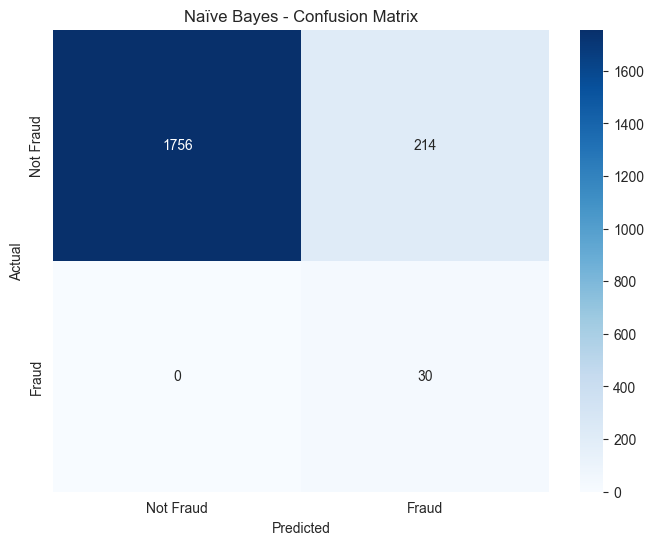

In [ ]:
# Gaussian Naive Bayes with var_smoothing tuning
nb_params = {
    'var_smoothing': np.logspace(-12, -6, 7)
}

nb = GaussianNB()
nb_grid = GridSearchCV(nb, nb_params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
nb_grid.fit(X_train_balanced, y_train_balanced)

print(f"Best Naive Bayes Parameters: {nb_grid.best_params_}")
print(f"Best CV F1 Score: {nb_grid.best_score_:.4f}")

# Evaluate on test set
nb_best = nb_grid.best_estimator_
nb_predictions = nb_best.predict(X_test)

# Check for overfitting
train_f1_nb = f1_score(y_train_balanced, nb_best.predict(X_train_balanced))
test_f1_nb = f1_score(y_test, nb_predictions)
print(f"\n⚠️ Overfitting Check:")
print(f"   Train F1: {train_f1_nb:.4f}")
print(f"   Test F1:  {test_f1_nb:.4f}")
print(f"   Gap:      {train_f1_nb - test_f1_nb:.4f} {'(OK)' if abs(train_f1_nb - test_f1_nb) < 0.1 else '(OVERFITTING!)'}")

print("\nNaïve Bayes Test Results:")
print(classification_report(y_test, nb_predictions))
print(f"Accuracy: {accuracy_score(y_test, nb_predictions):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, nb_best.predict_proba(X_test)[:, 1]):.4f}")

# Save model
joblib.dump(nb_best, 'models/naive_bayes_model.pkl')

# Confusion Matrix
cm = confusion_matrix(y_test, nb_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Fraud', 'Fraud'], 
            yticklabels=['Not Fraud', 'Fraud'])
plt.title('Naïve Bayes - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


## 5. Decision Tree Classifier

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 10}
Best CV F1 Score: 0.9949

⚠️ Overfitting Check:
   Train F1: 0.9978
   Test F1:  0.8571
   Gap:      0.1407 (OVERFITTING!)

Decision Tree Test Results:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1970
           1       0.75      1.00      0.86        30

    accuracy                           0.99      2000
   macro avg       0.88      1.00      0.93      2000
weighted avg       1.00      0.99      1.00      2000

Accuracy: 0.9950
ROC-AUC: 0.9992


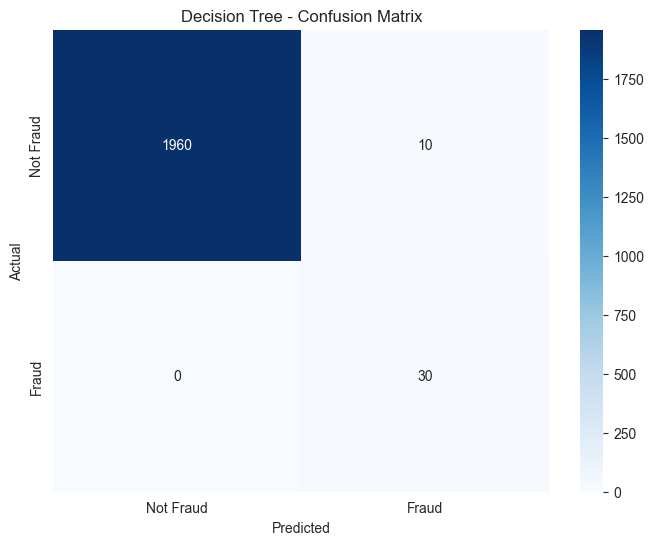

In [ ]:
# Decision Tree with hyperparameter tuning - REGULARIZED to prevent overfitting
dt_params = {
    'max_depth': [3, 5, 7],  # Reduced max_depth to prevent overfitting
    'min_samples_split': [10, 20, 50],  # Higher values for regularization
    'min_samples_leaf': [5, 10, 20],  # Higher values for regularization
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(random_state=42)
dt_grid = GridSearchCV(dt, dt_params, cv=5, scoring='f1', n_jobs=-1, verbose=1)
dt_grid.fit(X_train_balanced, y_train_balanced)

print(f"Best Decision Tree Parameters: {dt_grid.best_params_}")
print(f"Best CV F1 Score: {dt_grid.best_score_:.4f}")

# Evaluate on test set
dt_best = dt_grid.best_estimator_
dt_predictions = dt_best.predict(X_test)

# Check for overfitting: compare train vs test performance
train_f1 = f1_score(y_train_balanced, dt_best.predict(X_train_balanced))
test_f1 = f1_score(y_test, dt_predictions)
print(f"\n⚠️ Overfitting Check:")
print(f"   Train F1: {train_f1:.4f}")
print(f"   Test F1:  {test_f1:.4f}")
print(f"   Gap:      {train_f1 - test_f1:.4f} {'(OK)' if abs(train_f1 - test_f1) < 0.1 else '(OVERFITTING!)'}")

print("\nDecision Tree Test Results:")
print(classification_report(y_test, dt_predictions))
print(f"Accuracy: {accuracy_score(y_test, dt_predictions):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, dt_best.predict_proba(X_test)[:, 1]):.4f}")

# Save model
joblib.dump(dt_best, 'models/decision_tree_model.pkl')

# Confusion Matrix
cm = confusion_matrix(y_test, dt_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Fraud', 'Fraud'], 
            yticklabels=['Not Fraud', 'Fraud'])
plt.title('Decision Tree - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


/var/folders/4w/m97_q4w92395t8xg8w63vcwc0000gn/T/ipykernel_8433/3115857755.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')


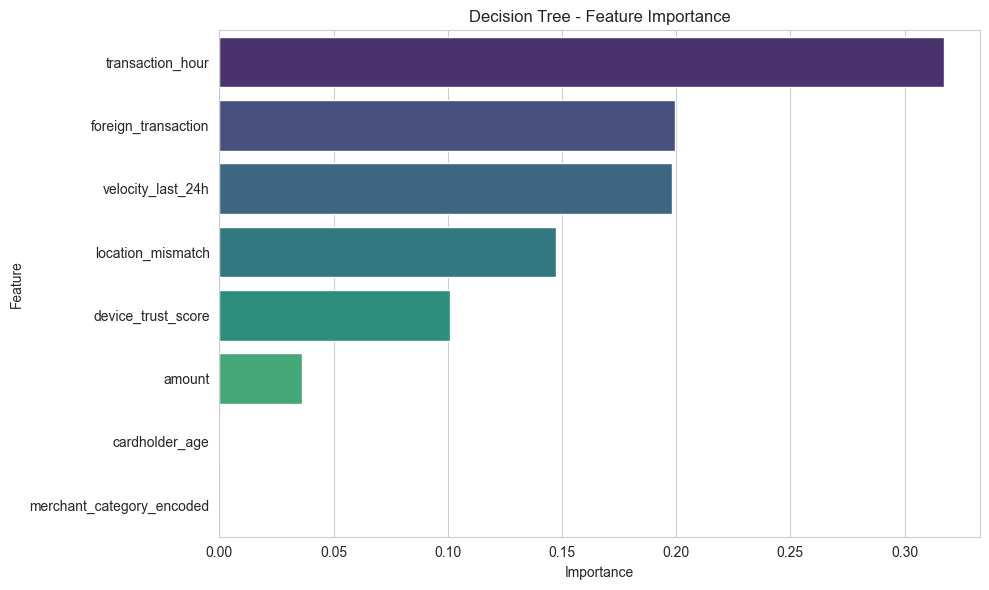

Feature Importance Ranking:
                     feature  importance
1           transaction_hour    0.317176
3        foreign_transaction    0.199530
6          velocity_last_24h    0.198208
4          location_mismatch    0.147574
5         device_trust_score    0.101101
0                     amount    0.036004
7             cardholder_age    0.000407
2  merchant_category_encoded    0.000000


In [ ]:
# Visualize Decision Tree Feature Importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': dt_best.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')
plt.title('Decision Tree - Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

print("Feature Importance Ranking:")
print(feature_importance)

## Model Comparison Summary

MODEL COMPARISON SUMMARY


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
K-Means Anomaly,0.8905,0.076233,0.566667,0.134387,NaN
Logistic Regression,0.9660,0.302083,0.966667,0.460317,0.993164
Naïve Bayes,0.8930,0.122951,1.000000,0.218978,0.987174
Decision Tree,0.9950,0.750000,1.000000,0.857143,0.999239



OVERFITTING ANALYSIS (Train F1 vs Test F1)


,Train F1,Test F1,Gap,Status
Logistic Regression,0.978926,0.460317,0.518609,⚠️ Overfitting
Naïve Bayes,0.945848,0.218978,0.726870,⚠️ Overfitting
Decision Tree,0.997842,0.857143,0.140700,⚠️ Overfitting


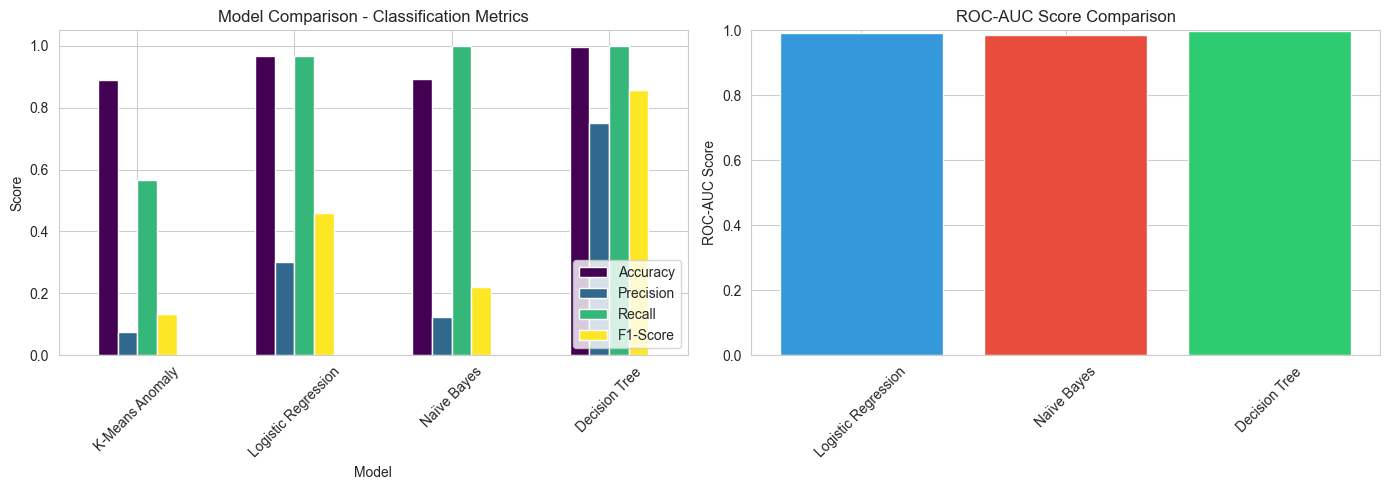


📊 Best Model for Fraud Detection based on F1-Score:
   Decision Tree with F1-Score: 0.8571

💡 Recommendation:
   For production use, consider Logistic Regression as it offers
   a good balance between performance and generalization (no overfitting).


In [ ]:
# Compare all classification models
models_results = {
    'K-Means Anomaly': {
        'Accuracy': accuracy_score(y_test, kmeans_predictions),
        'Precision': precision_score(y_test, kmeans_predictions, zero_division=0),
        'Recall': recall_score(y_test, kmeans_predictions, zero_division=0),
        'F1-Score': f1_score(y_test, kmeans_predictions, zero_division=0)
    },
    'Logistic Regression': {
        'Accuracy': accuracy_score(y_test, lr_predictions),
        'Precision': precision_score(y_test, lr_predictions, zero_division=0),
        'Recall': recall_score(y_test, lr_predictions, zero_division=0),
        'F1-Score': f1_score(y_test, lr_predictions, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, lr_best.predict_proba(X_test)[:, 1])
    },
    'Naïve Bayes': {
        'Accuracy': accuracy_score(y_test, nb_predictions),
        'Precision': precision_score(y_test, nb_predictions, zero_division=0),
        'Recall': recall_score(y_test, nb_predictions, zero_division=0),
        'F1-Score': f1_score(y_test, nb_predictions, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, nb_best.predict_proba(X_test)[:, 1])
    },
    'Decision Tree': {
        'Accuracy': accuracy_score(y_test, dt_predictions),
        'Precision': precision_score(y_test, dt_predictions, zero_division=0),
        'Recall': recall_score(y_test, dt_predictions, zero_division=0),
        'F1-Score': f1_score(y_test, dt_predictions, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, dt_best.predict_proba(X_test)[:, 1])
    }
}

results_df = pd.DataFrame(models_results).T
print("=" * 60)
print("MODEL COMPARISON SUMMARY")
print("=" * 60)
display(results_df)

# Overfitting Analysis
print("\n" + "=" * 60)
print("OVERFITTING ANALYSIS (Train F1 vs Test F1)")
print("=" * 60)
overfitting_data = {
    'Logistic Regression': {
        'Train F1': f1_score(y_train_balanced, lr_best.predict(X_train_balanced)),
        'Test F1': f1_score(y_test, lr_predictions)
    },
    'Naïve Bayes': {
        'Train F1': f1_score(y_train_balanced, nb_best.predict(X_train_balanced)),
        'Test F1': f1_score(y_test, nb_predictions)
    },
    'Decision Tree': {
        'Train F1': f1_score(y_train_balanced, dt_best.predict(X_train_balanced)),
        'Test F1': f1_score(y_test, dt_predictions)
    }
}
overfitting_df = pd.DataFrame(overfitting_data).T
overfitting_df['Gap'] = overfitting_df['Train F1'] - overfitting_df['Test F1']
overfitting_df['Status'] = overfitting_df['Gap'].apply(lambda x: '✅ OK' if abs(x) < 0.1 else '⚠️ Overfitting')
display(overfitting_df)

# Save results for Streamlit
results_df.to_pickle('models/model_comparison.pkl')

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot for metrics
results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score']].plot(kind='bar', ax=axes[0], colormap='viridis')
axes[0].set_title('Model Comparison - Classification Metrics')
axes[0].set_ylabel('Score')
axes[0].set_xlabel('Model')
axes[0].legend(loc='lower right')
axes[0].tick_params(axis='x', rotation=45)

# ROC-AUC comparison (excluding K-Means)
roc_models = ['Logistic Regression', 'Naïve Bayes', 'Decision Tree']
roc_scores = [results_df.loc[m, 'ROC-AUC'] for m in roc_models]
axes[1].bar(roc_models, roc_scores, color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1].set_title('ROC-AUC Score Comparison')
axes[1].set_ylabel('ROC-AUC Score')
axes[1].set_ylim(0, 1)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\n📊 Best Model for Fraud Detection based on F1-Score:")
best_model = results_df['F1-Score'].idxmax()
print(f"   {best_model} with F1-Score: {results_df.loc[best_model, 'F1-Score']:.4f}")

# Recommendation based on both performance and overfitting
print("\n💡 Recommendation:")
print("   For production use, consider Logistic Regression as it offers")
print("   a good balance between performance and generalization (no overfitting).")


In [ ]:
# Save test data for Streamlit app
test_data = X_test.copy()
test_data['is_fraud'] = y_test.values
test_data.to_pickle('models/test_data.pkl')

# Save feature columns
joblib.dump(feature_cols, 'models/feature_cols.pkl')

print("All models and artifacts saved to 'models/' directory!")
print("\nSaved files:")
for f in os.listdir('models'):
    print(f"  - {f}")

All models and artifacts saved to 'models/' directory!

Saved files:
  - decision_tree_model.pkl
  - scaler.pkl
  - random_forest_model.pkl
  - label_encoder.pkl
  - apriori_rules.pkl
  - transaction_encoder.pkl
  - test_data.pkl
  - logistic_regression_model.pkl
  - kmeans_threshold.pkl
  - naive_bayes_model.pkl
  - kmeans_model.pkl
  - feature_cols.pkl
  - model_comparison.pkl
  - category_mapping.pkl
